In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import openpathsampling as paths
import ops_piggybacker as oink

## Create fake trajectories

The input trajectories for the one-way shooting version must

* not include the shooting point (which is shared between the two trajectories)
* be in forward-time order (so reversed paths, which are created as time goes backward, need to be reversed)


In [2]:
from openpathsampling.tests.test_helpers import make_1d_traj

traj1 = make_1d_traj([-0.9, 0.1, 1.1, 2.1, 3.1, 4.1, 5.1, 6.1, 7.1, 8.1, 9.1, 10.1])
traj2 = make_1d_traj([-0.8, 1.2])
traj3 = make_1d_traj([5.3, 8.3, 11.3])
traj4 = make_1d_traj([-0.6, 1.4, 3.4, 5.4, 7.4])
traj5 = make_1d_traj([-0.5, 0.5, 1.5, 2.5, 3.5, 4.5, 5.5])

## Make list of move data

The input to the pseudo-simulator is a list of data related to the move. For one-way shooting, you need the following information with each move:

* the replica this move applies to (for TPS, just use `0`)
* the single-direction trajectory (as described in the previous section)
* the index of the shooting point from the previous *full* trajectory
* whether the trajectory was accepted
* the direction of the one-way shooting move (forward is `+1`, backward is `-1`)

The `moves` object below is a list of tuples of that information, in the order listed above. This is what you need to create from your previous simulation.

In [3]:
moves = [
    (0, traj2, 3, True, -1),
    (0, traj3, 4, True, +1),
    (0, traj4, 6, False, -1),
    (0, traj5, 6, True, -1)
]

From here, you've already done everything that needs to be done to reshape your already-run simulation. Now you just need to create the fake OPS simulations.

## Create OPS objects

In [4]:
# volumes
cv = paths.FunctionCV("x", lambda snap: snap.xyz[0][0])
left_state = paths.CVDefinedVolume(cv, float("-inf"), 0.0)
right_state = paths.CVDefinedVolume(cv, 10.0, float("inf"))

In [5]:
# network
network = paths.TPSNetwork(left_state, right_state)
ensemble = network.sampling_ensembles[0]  # the only one

## Create initial conditions

In [6]:
initial_conditions = paths.SampleSet([
        paths.Sample(replica=0,
                     trajectory=traj1,
                     ensemble=ensemble)
])

## Create OPSPiggybacker objects

Note that the big difference here is that you use `pre_joined=False`. This is essential for the automated one-way shooting treatment.

In [7]:
shoot = oink.ShootingStub(ensemble, pre_joined=False)

In [8]:
sim = oink.ShootingPseudoSimulator(storage=paths.Storage('one_way.nc', 'w'),
                                   initial_conditions=initial_conditions,
                                   mover=shoot,
                                   network=network)

## Run the pseudo-simulator

In [9]:
sim.run(moves)

In [10]:
sim.storage.close()

## Analyze with OPS

In [11]:
analysis_file = paths.AnalysisStorage("one_way.nc")

In [12]:
scheme = analysis_file.schemes[0]
scheme.move_summary(analysis_file.steps)

shooting ran 100.000% (expected 100.00%) of the cycles with acceptance 3/4 (75.00%)


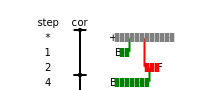

In [13]:
import openpathsampling.visualize as ops_vis
from IPython.display import SVG
history = ops_vis.PathTree(
    analysis_file.steps,
    ops_vis.ReplicaEvolution(replica=0)
)
# switch to the "boxcar" look for the trajectories
history.options.movers['default']['new'] = 'single'
history.options.css['horizontal_gap'] = True
SVG(history.svg())

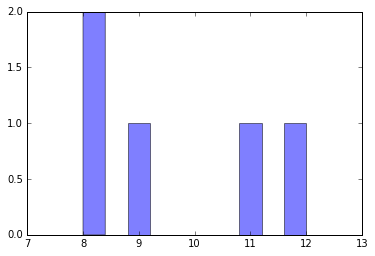

In [14]:
path_lengths = [len(step.active[0].trajectory) for step in analysis_file.steps]
plt.hist(path_lengths, alpha=0.5);

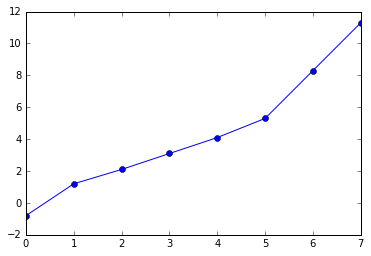

In [15]:
cv_x = analysis_file.cvs['x']
# load the active trajectory as storage.steps[step_num].active[replica_id]
plt.plot(cv_x(analysis_file.steps[2].active[0]), 'o-');